<a href="https://colab.research.google.com/github/Corry-Grodek/DataScience/blob/main/Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns



In [ ]:
!pip install pymc-bart
import pymc_bart as pmb

In [ ]:
from sklearn import tree

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

**Decision trees splits the predictor values into smaller buckets, or branches, and finds a median for each branch. The amount of branches is the amount of medians that stitched together. The splitting proccess is computationally simple so the model runs pretty fast**

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

**The depth is how many subdivisions the tree has, or how many times a node is split. A tree is too deep if it starts overfitting, for example creating branches dedicated to a few outliers, or showing trends that do not exist.**

**Task4:**

How are BART models similar and different from a decision tree?

**A BART model is a combiation of many random decision trees. It uses a similar process to decisions trees, but because there are many of them overlapping it the prevents overftting seen in single decision trees with high depths.**

**Task5**:

Why would we use a BART model instead of a decision tree?

**BART models will be better for large data sets with more complex trends. Plain decision trees will be better for small data sets.**

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [ ]:
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [ ]:
X = penguins["flipper_length"].to_numpy().reshape(-1, 1)
#Y is the predicted variable, body_mass
Y = penguins["body_mass"].to_numpy()


(array([14., 42., 69., 52., 41., 39., 27., 27., 16.,  6.]),
 array([2.7 , 3.06, 3.42, 3.78, 4.14, 4.5 , 4.86, 5.22, 5.58, 5.94, 6.3 ]),
 <BarContainer object of 10 artists>)

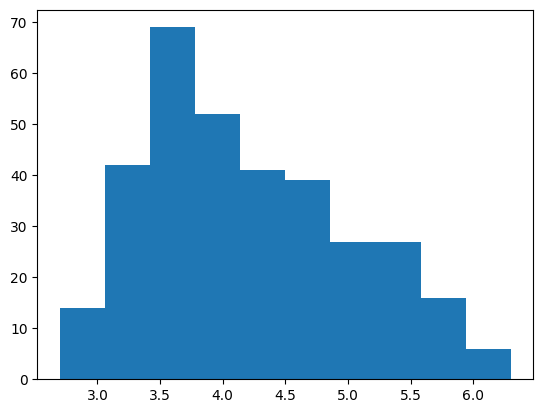

In [ ]:
plt.hist(penguins.body_mass)

In [ ]:
with pm.Model() as model_penguins:
    s = pm.HalfNormal('s',4)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_penguins = pm.sample(compute_convergence_checks=False)


Output()

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [ ]:
posterior_mean = idata_penguins.posterior["μ"]

pm.sample_posterior_predictive(idata_penguins,model_penguins, extend_inferencedata=True)

μ_hdi = az.hdi(ary=idata_penguins, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract( idata_penguins, group="posterior_predictive", var_names=["y"] ).T

Output()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


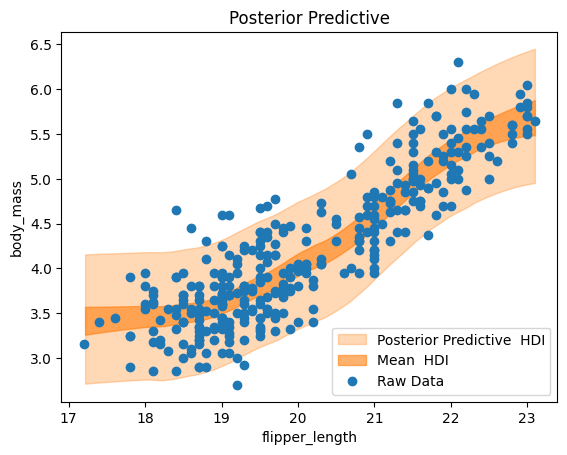

In [ ]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive  HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean  HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

**I was suprised by how well this worked! The models seems to follow the S curve trend very well and the HDI even seems to be very accurate! The model shows the positive relationship, and shows the slight plateau at the high and low ends of flipper length. There are a few outliers at above the prediction line but otherwise the model seems to be very accurate.**

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

In [ ]:
clmn_list = ['species',
             'island',
             'bill_length',
             'bill_depth',
             'flipper_length',
             'body_mass',
             'sex',
             'year',
             ]
peng_stats =  penguins.loc[:,clmn_list]

peng_nona = peng_stats.dropna()

X = peng_nona[[
             'bill_length',
             'flipper_length',
             'bill_depth',
             ]]

In [ ]:
with pm.Model() as model_penguins:
    s = pm.HalfNormal('s',4)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_penguins = pm.sample(compute_convergence_checks=False)

pm.sample_posterior_predictive(idata_penguins,model_penguins, extend_inferencedata=True)

Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

array([<Axes: xlabel='bill_length'>, <Axes: xlabel='flipper_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

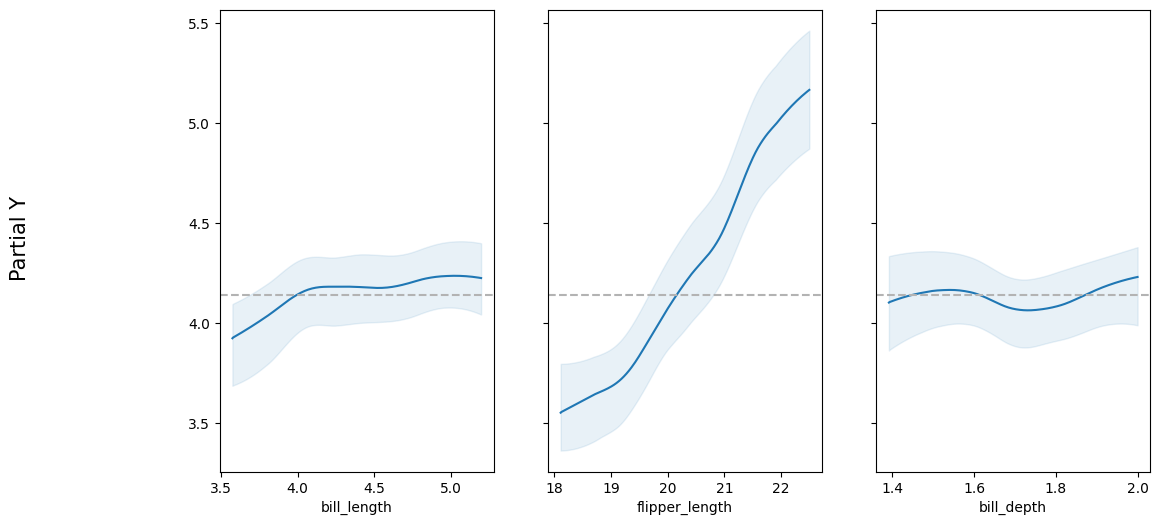

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 3), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='bill_length'>, <Axes: xlabel='flipper_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

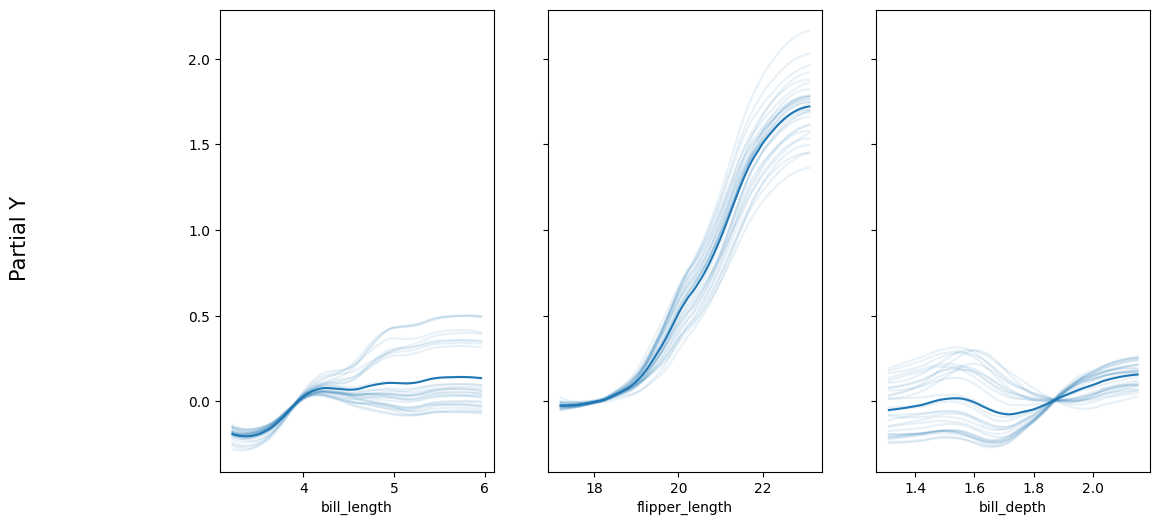

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 3), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

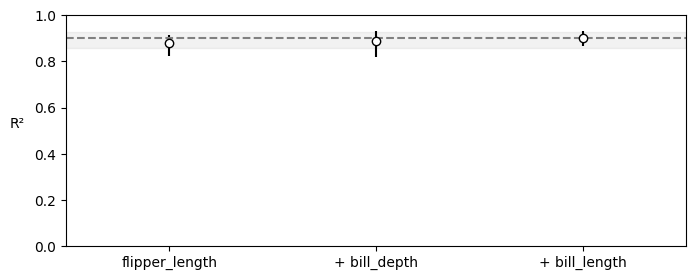

In [ ]:
vi_penguins = pmb.compute_variable_importance(idata_penguins, μ_, X)

pmb.plot_variable_importance(vi_penguins)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

**Based on the plots, flipper length and bill length are the best options to predict body mass. They both had a positive relationship with body mass, with flipper length having a stronger correlation. Both variables also have fairly parallel data in the ICE plot. All of the varibles had a pretty similar R^2 so they should all run about the same.**